In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
Folder_Path = "/content/drive/MyDrive/2020TM/"

News_Category_Dataset = Folder_Path+"/News_Category_Dataset_v2.json"
All_the_news_Dataset = [
  Folder_Path+"/articles1.csv",
  Folder_Path+"/articles2.csv",
  Folder_Path+"/articles3.csv"
]

In [ ]:
def load_train():
  data = pd.read_json(News_Category_Dataset, lines=True)
  data.rename(columns={
    'headline': 'title',
    'authors': 'author',
    'short_description': 'short_content'
  }, inplace=True)
  data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
  return data

def load_test():
  all_data = []
  for file in All_the_news_Dataset:
    all_data.append(pd.read_csv(file))
  all_data = pd.concat(all_data)
  all_data['date'] = pd.to_datetime(all_data['date'], format='%Y-%m-%d')
  return all_data

##load data and drop useless column

In [ ]:
#load data
df_train = load_train()
df_test = load_test()
df_train.drop(['link'], axis=1, inplace=True)
df_test.drop(['Unnamed: 0', 'id', 'url', 'year', 'month'], axis=1, inplace=True)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   category       200853 non-null  object        
 1   title          200853 non-null  object        
 2   author         200853 non-null  object        
 3   short_content  200853 non-null  object        
 4   date           200853 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(4)
memory usage: 7.7+ MB


In [ ]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142570 entries, 0 to 42570
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   title        142568 non-null  object        
 1   publication  142570 non-null  object        
 2   author       126694 non-null  object        
 3   date         139929 non-null  datetime64[ns]
 4   content      142570 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 6.5+ MB


###deal with NaN

there's NaN in testing data

so we need to handle it

In [ ]:
df_train[df_train.title.str.len()<10].head()

,category,title,author,short_content,date
7826,POLITICS,War Pay,"William D. Hartung, ContributorWriter and Fore...",Another good year for weapons makers is guaran...,2018-01-11
10904,POLITICS,What If?,"Danny Sjursen, ContributorU.S. Army strategist...",An alternative strategy for 9/12/2001.,2017-11-27
11326,GREEN,Nebraska,"Michael Brune, ContributorExecutive Director, ...","We must continue to promote clean, renewable e...",2017-11-20
11645,POLITICS,Impeach!,"Michael Moore, ContributorOscar and Emmy-winni...",We can't wait until November 2020.,2017-11-16
12061,POLITICS,Victory!,"Barbara Boxer, ContributorFormer U.S. Senator;...",Can You Believe? Can you believe Trump’s sayin...,2017-11-10


In [ ]:
df_train = df_train[df_train.short_content.str.len()>50]
df_train = df_train[df_train.title.str.len()>10]
df_train.loc[df_train.author.str.len()==0, 'author'] = "other_author"
df_train.reset_index(drop=True, inplace=True)
df_train.shape

(155291, 5)

In [ ]:
df_test.dropna(subset=['title', 'date'], inplace=True)
df_test['author'].fillna("other_author", inplace=True)
df_test = df_test[df_test.content.str.len()>100]
df_test.reset_index(drop=True, inplace=True)
df_test.shape

(139480, 5)

### Category(training data)

since training content is short

we cancat title with short_content as training data

In [ ]:
#train feature
training = pd.DataFrame()
training['id']    = np.arange(1, df_train.shape[0]+1)
training['data']   = df_train['title'] + " " + df_train['short_content']
training['author']  = df_train.author
training['date']   = df_train.date
training['category'] = df_train.category
training.head()
del df_train

training的分類有重複

把其中相似的種類合併

In [ ]:
categories = training.groupby('category')
print('total categories: {}'.format(categories.ngroups))
print(categories.size())

total categories: 41
category
ARTS                851
ARTS & CULTURE      996
BLACK VOICES       3602
BUSINESS           4757
COLLEGE             866
COMEDY             2723
CRIME              2378
CULTURE & ARTS      997
DIVORCE            3384
EDUCATION           880
ENTERTAINMENT      8446
ENVIRONMENT        1318
FIFTY              1040
FOOD & DRINK       4837
GOOD NEWS           615
GREEN              1897
HEALTHY LIVING     4358
HOME & LIVING      3489
IMPACT             2905
LATINO VOICES       847
MEDIA              1965
MONEY              1702
PARENTING          8554
PARENTS            2710
POLITICS          25200
QUEER VOICES       4859
RELIGION           1687
SCIENCE            1565
SPORTS             2984
STYLE               607
STYLE & BEAUTY     8951
TASTE              1182
TECH               1670
THE WORLDPOST      3271
TRAVEL             9022
WEDDINGS           3619
WEIRD NEWS         1070
WELLNESS          17708
WOMEN              2556
WORLD NEWS         1993
WORLDPOST 

In [ ]:
#train label
training['category'] = training.category.map(lambda x: "WORLD NEWS" if x == "WORLD NEWS" or x == "WORLDPOST" else x)
training['category'] = training.category.map(lambda x: "RACIAL & LGBTQ ISSUES" if x == "BLACK VOICES" or x == "LATINO VOICES" or x == "QUEER VOICES" else x)
training['category'] = training.category.map(lambda x: "CULTURE" if x == "ARTS" or x == "CULTURE & ARTS" or x == "ARTS & CULTURE" else x)
training['category'] = training.category.map(lambda x: "BUSINESS" if x == "BUSINESS" or x == "MONEY" else x)
training['category'] = training.category.map(lambda x: "EDUCATION" if x == "EDUCATION" or x == "COLLEGE" else x)
training['category'] = training.category.map(lambda x: "SCIENCE & TECHNOLOGY" if x == "SCIENCE" or x == "TECH" else x)
training['category'] = training.category.map(lambda x: "WEDDING & DIVORCE" if x == "WEDDING" or x == "DIVORCE" or x == "WEDDINGS" else x)
training['category'] = training.category.map(lambda x: "PARENTING" if x == "PARENTING" or x == "PARENT" or x == "PARENTS" else x)
training['category'] = training.category.map(lambda x: "FOOD" if x == "TASTE" or x == "FOOD & DRINK" else x)
training['category'] = training.category.map(lambda x: "STYLE & BEAUTY" if x == "STYLE" or x == "STYLE & BEAUTY" else x)



categories = training.groupby('category')
print('total categories: {}'.format(categories.ngroups))
print(categories.size())

total categories: 29
category
BUSINESS                  6459
COMEDY                    2723
CRIME                     2378
CULTURE                   2844
EDUCATION                 1746
ENTERTAINMENT             8446
ENVIRONMENT               1318
FIFTY                     1040
FOOD                      6019
GOOD NEWS                  615
GREEN                     1897
HEALTHY LIVING            4358
HOME & LIVING             3489
IMPACT                    2905
MEDIA                     1965
PARENTING                11264
POLITICS                 25200
RACIAL & LGBTQ ISSUES     9308
RELIGION                  1687
SCIENCE & TECHNOLOGY      3235
SPORTS                    2984
STYLE & BEAUTY            9558
THE WORLDPOST             3271
TRAVEL                    9022
WEDDING & DIVORCE         7003
WEIRD NEWS                1070
WELLNESS                 17708
WOMEN                     2556
WORLD NEWS                3223
dtype: int64


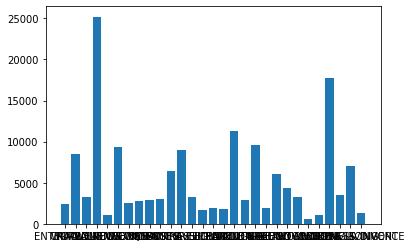

In [ ]:
from collections import Counter
from matplotlib import pyplot

counter = Counter(training['category'])
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

###Testing data

In [ ]:
testing = pd.DataFrame()
testing['id']   = np.arange(1, df_test.shape[0]+1)
testing['data']  = df_test['title'] + " " + df_test['content']
testing['author'] = df_test.author
testing['date']  = df_test.date
testing['publication'] = df_test.publication
testing.head()
#del df_test

,id,data,author,date,publication
0,1,House Republicans Fret About Winning Their Hea...,Carl Hulse,2016-12-31,New York Times
1,2,Rift Between Officers and Residents as Killing...,Benjamin Mueller and Al Baker,2017-06-19,New York Times
2,3,"Tyrus Wong, ‘Bambi’ Artist Thwarted by Racial ...",Margalit Fox,2017-01-06,New York Times
3,4,"Among Deaths in 2016, a Heavy Toll in Pop Musi...",William McDonald,2017-04-10,New York Times
4,5,Kim Jong-un Says North Korea Is Preparing to T...,Choe Sang-Hun,2017-01-02,New York Times


## Sentence Preprocess

Tokenize and Stemming

In [ ]:
import nltk
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

TF_vectorizer = CountVectorizer(stop_words='english', decode_error='ignore', min_df=10)
train_tf_vec = TF_vectorizer.fit_transform(training.data)
print("training term frequency:")
print(train_tf_vec.shape)
test_tf_vec = TF_vectorizer.transform(testing.data)
print("testing term frequency:")
print(test_tf_vec.shape)

print("y_train:")
print(training.category.shape)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


KeyboardInterrupt: ignored

### Tokenize

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
class CountVectorizer():
  def _analyze(doc)
    if decoder is not None:
      doc = decoder(doc)
    if analyzer is not None:
      doc = analyzer(doc)
    else:
      if preprocessor is not None:
        doc = preprocessor(doc)
      if tokenizer is not None:
        doc = tokenizer(doc)
    return doc


from sklearn.feature_extraction.text import CountVectorizer
from nltk import PorterStemmer
stemmer = PorterStemmer()

class StemmedCountVectorizer(CountVectorizer):
  def build_analyzer(self):
    analyzer = super(StemmedCountVectorizer, self).build_analyzer()
    return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)]) 


  

In [ ]:
V <- vocabs
for doc <- 1 to D
do tokens = _analyze(doc)
  N <- len(tokens)
  for i <- 1 to N
  do term = stem(tokens[i]) 
    idx = V.argwhere(term)
    TF[doc][idx] += 1

V <- vocabs
for doc <- 1 to D
do tokens = _analyze(doc)
  N <- len(tokens)
  for i <- 1 to N
  do term = tokens[i]
    idx = V.argwhere(term)
    TF[doc][idx] += 1

T <- len(V)
for t <- 1 to T
do term = stem(V[t])
  idx = V.argwhere(V[t])
  s_TF[idx] += transpose(TF)[t] //vector add

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk import PorterStemmer
stemmer = PorterStemmer()

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

TF_vectorizer = CountVectorizer(stop_words='english', decode_error='ignore', min_df=10)

In [ ]:
train_tf_vec = TF_vectorizer.fit_transform(training.data)
print("training term frequency:")
print(train_tf_vec.shape)
test_tf_vec = TF_vectorizer.transform(testing.data)
print("testing term frequency:")
print(test_tf_vec.shape)

print("y_train:")
print(training.category.shape)

training term frequency:
(155291, 20387)
testing term frequency:
(139480, 20387)
y_train:
(155291,)


In [ ]:
np.save(Folder_Path + '/train_TF', train_tf_vec)
np.save(Folder_Path + '/test_TF', test_tf_vec)

In [ ]:
train_vec = np.load((Folder_Path+'/train_TF.npy'), allow_pickle=True).item()
test_vec = np.load((Folder_Path + '/test_TF.npy'), allow_pickle=True).item()

### stemming

#### map vocab to stemmed vocab

In [ ]:
from scipy.sparse import csr_matrix
from nltk import PorterStemmer
stemmer = PorterStemmer()

all_vocab = TF_vectorizer.get_feature_names()
vocabs = np.array([stemmer.stem(i) for i in TF_vectorizer.vocabulary_.keys()])
stemmed_vocab = np.array(list(set(vocabs)))
print("all vocab count:", len(vocabs))
print("stemmed vocab count:", len(stemmed_vocab))
#vocab_stem_mapping = np.empty((vocabs.shape[0], stemmed_vocab.shape[0]), dtype=np.int)
vocab_stem_mapping = np.empty((stemmed_vocab.shape[0]), dtype=np.object)
for i in range(len(stemmed_vocab)):
  #stem_mapping = (vocabs == stemmed_vocab[i])
  #vocab_stem_mapping[:, i] = stem_mapping
  stem_mapping = np.where(vocabs == stemmed_vocab[i])[0]
  vocab_stem_mapping[i] = stem_mapping
  if(i%1000 == 0):
    print(i, end=" ")

all vocab count: 20387
stemmed vocab count: 12795
0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 

how to use:

In [ ]:
index = 1
# select column for one stemmed vocab
print("index of original vocab:\n", vocab_stem_mapping[index])
print("original vocab:\n", all_vocab[vocab_stem_mapping[index]])
print("vocab after stemming:\n", stemmed_vocab[index])
#del all_vocab, vocabs, stemmed_vocab

index of original vocab:
 [16408]


TypeError: ignored

In [ ]:
#col = 100
# select column for one stemmed vocab
#print("index of original vocab:\n", np.where(vocab_stem_mapping[:,col]==True))
#print("original vocab:\n", all_vocab[np.where(vocab_stem_mapping[:,col]==True)])
#print("vocab after stemming:\n", stemmed_vocab[col])
#del all_vocab, vocabs, stemmed_vocab

#### map TF array to stemmed TF array

In [ ]:
#train_stemmed_shape = (train_tf_vec.shape[0], vocab_stem_mapping.shape[1])
#test_stemmed_shape = (test_tf_vec.shape[0], vocab_stem_mapping.shape[1])
#print("old train shape", train_tf_vec.shape)
#print("old test shape", test_tf_vec.shape)
#print("new train shape", train_stemmed_shape)
#print("new test shape", test_stemmed_shape)
#print()

#print("new train  \t = old train \t\tx \tvocab_stem_mapping")
#print(train_stemmed_shape, "=", train_tf_vec.shape, "\tx\t", vocab_stem_mapping.shape)

#train_stemmed_TF = csr_matrix((train_tf_vec.shape[0], vocab_stem_mapping.shape[1]))
#train_stemmed_TF.shape
#train_stemmed_TF = train_tf_vec.dot(vocab_stem_mapping.astype('int'))

這個東東要跑一個小時...

所以還是用save load好ㄌ

In [ ]:
# training
print(vocab_stem_mapping.shape[0])
train_stemmed_TF = csr_matrix((train_tf_vec.shape[0], vocab_stem_mapping.shape[0]))
test_stemmed_TF = csr_matrix((test_tf_vec.shape[0], vocab_stem_mapping.shape[0]))

train_stemmed_TF = train_stemmed_TF.tolil()
test_stemmed_TF = test_stemmed_TF.tolil()
for i in range(len(stemmed_vocab)):
  #for j in vocab_stem_mapping[i]:
  #  print(j)
  #  train_stemmed_TF[:, i] = np.add(train_stemmed_TF[:, i], train_tf_vec[:, j])
  train_stemmed_TF[:, i] = train_tf_vec[:, vocab_stem_mapping[i]].sum(axis=1)
  test_stemmed_TF[:, i] = test_tf_vec[:, vocab_stem_mapping[i]].sum(axis=1)
  if(i%200 == 0):
    print(i, end='/{:d}\t'.format(len(stemmed_vocab)))
train_stemmed_TF = train_stemmed_TF.tocsr()
test_stemmed_TF = test_stemmed_TF.tocsr()

12795
0/12795	200/12795	400/12795	600/12795	800/12795	1000/12795	1200/12795	

In [ ]:
np.save(Folder_Path+'train_stem_TF.npy', train_stemmed_TF)
np.save(Folder_Path+'test_stem_TF.npy', test_stemmed_TF)

In [ ]:
train_x = np.load((Folder_Path + '/train_stem_TF.npy'), allow_pickle=True).item()
test_x = np.load((Folder_Path + '/test_stem_TF.npy'), allow_pickle=True).item()

In [ ]:
all_vocab = np.array(TF_vectorizer.get_feature_names())
np.save('/content/drive/MyDrive/2020TM/train_TF.npy', train_tf_vec)
np.save('/content/drive/MyDrive/2020TM/test_TF.npy', test_tf_vec)
np.save('/content/drive/MyDrive/2020TM/all_vocab.npy', all_vocab)

In [ ]:
from scipy.sparse import csr_matrix
from nltk import PorterStemmer
stemmer = PorterStemmer()

all_vocab = np.array(TF_vectorizer.get_feature_names())
vocabs = np.array([stemmer.stem(i) for i in all_vocab])
stemmed_vocab = np.array(list(set(vocabs)))
vocab_stem_mapping = np.empty((stemmed_vocab.shape[0]), dtype=np.object)
for i in range(len(stemmed_vocab)):
  #stem_mapping = (vocabs == stemmed_vocab[i])
  #vocab_stem_mapping[:, i] = stem_mapping
  stem_mapping = np.where(vocabs == stemmed_vocab[i])[0]
  vocab_stem_mapping[i] = stem_mapping
  if(i%1000 == 0):
    print(i, end=" ")

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 

In [ ]:
index = 200
# select column for one stemmed vocab
print("index of original vocab:\n", vocab_stem_mapping[index])
print("original vocab:\n", all_vocab[vocab_stem_mapping[index]])
print("vocab after stemming:\n", stemmed_vocab[index])
#del all_vocab, vocabs, stemmed_vocab

index of original vocab:
 [16783 16784]
original vocab:
 ['smartphone' 'smartphones']
vocab after stemming:
 smartphon


In [ ]:
# training
print(vocab_stem_mapping.shape[0])
train_stemmed_TF = csr_matrix((train_tf_vec.shape[0], vocab_stem_mapping.shape[0]))
test_stemmed_TF = csr_matrix((test_tf_vec.shape[0], vocab_stem_mapping.shape[0]))

train_stemmed_TF = train_stemmed_TF.tolil()
test_stemmed_TF = test_stemmed_TF.tolil()
for i in range(len(stemmed_vocab)):
  #for j in vocab_stem_mapping[i]:
  #  print(j)
  #  train_stemmed_TF[:, i] = np.add(train_stemmed_TF[:, i], train_tf_vec[:, j])
  train_stemmed_TF[:, i] = train_tf_vec[:, vocab_stem_mapping[i]].sum(axis=1)
  test_stemmed_TF[:, i] = test_tf_vec[:, vocab_stem_mapping[i]].sum(axis=1)
  if(i%200 == 0):
    print("{:d}/{:d}".format(i, len(stemmed_vocab)), end="\t")
train_stemmed_TF = train_stemmed_TF.tocsr()
test_stemmed_TF = test_stemmed_TF.tocsr()

np.save('/content/drive/MyDrive/2020TM/train_stem_TF.npy', train_stemmed_TF)
np.save('/content/drive/MyDrive/2020TM/test_stem_TF.npy', test_stemmed_TF)
np.save('/content/drive/MyDrive/2020TM/stemmed_vocab.npy', stemmed_vocab)

12795
0/12795	200/12795	400/12795	600/12795	800/12795	1000/12795	1200/12795	1400/12795	1600/12795	1800/12795	2000/12795	2200/12795	2400/12795	2600/12795	2800/12795	3000/12795	3200/12795	3400/12795	3600/12795	3800/12795	4000/12795	4200/12795	4400/12795	4600/12795	4800/12795	5000/12795	5200/12795	5400/12795	5600/12795	5800/12795	6000/12795	6200/12795	6400/12795	6600/12795	6800/12795	7000/12795	7200/12795	7400/12795	7600/12795	7800/12795	8000/12795	8200/12795	8400/12795	8600/12795	8800/12795	9000/12795	9200/12795	9400/12795	9600/12795	9800/12795	10000/12795	10200/12795	10400/12795	10600/12795	10800/12795	11000/12795	11200/12795	11400/12795	11600/12795	11800/12795	12000/12795	12200/12795	12400/12795	12600/12795	

In [ ]:
TF_train_all = np.load('/content/drive/MyDrive/2020TM/train_TF.npy', allow_pickle=True).item()
TF_test_all = np.load('/content/drive/MyDrive/2020TM/test_TF.npy', allow_pickle=True).item()
all_vocab = np.load('/content/drive/MyDrive/2020TM/all_vocab.npy', allow_pickle=True)
all_vocab

array(['00', '000', '007', ..., 'zuckerberg', 'zumba', 'zurich'],
      dtype='<U24')

In [ ]:
TF_train_x = np.load('/content/drive/MyDrive/2020TM/train_stem_TF.npy', allow_pickle=True).item()
TF_test_x = np.load('/content/drive/MyDrive/2020TM/test_stem_TF.npy', allow_pickle=True).item()
stemmed_vocab = np.load('/content/drive/MyDrive/2020TM/stemmed_vocab.npy', allow_pickle=True)
stemmed_vocab

array(['sesam', 'introvert', 'unborn', ..., 'condom', 'territori',
       'sniper'], dtype='<U24')

In [ ]:
TF_train_x.shape

(155291, 12795)

### calculate tfidf vector

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer()
x_train = transformer.fit_transform(TF_train_x)
x_test = transformer.transform(TF_test_x)

## further merge category to fewer topic

In [ ]:
training['category'] = training.category.map(lambda x: "HOME & LIVING" if x == "HOME & LIVING" or x == "STYLE & BEAUTY" else x)
training['category'] = training.category.map(lambda x: "ENVIRONMENT" if x == "ENVIRONMENT" or x == "GREEN" else x)
training['category'] = training.category.map(lambda x: "HEALTHY LIVING" if x == "HEALTHY LIVING" or x == "WELLNESS" else x)
training['category'] = training.category.map(lambda x: "THE WORLDPOST" if x == "THE WORLDPOST" or x == "WORLD NEWS" else x)
training['category'] = training.category.map(lambda x: "FIFTY" if x == "FIFTY" or x == "WEDDING & DIVORCE" else x)
training['category'] = training.category.map(lambda x: "IMPACT" if x == "IMPACT" or x == "WOMEN" else x)
training['category'] = training.category.map(lambda x: "FIFTY" if x == "FIFTY" or x == "GOOD NEWS" else x)
training['category'] = training.category.map(lambda x: "CRIME" if x == "CRIME" or x == "WEIRD NEWS" else x)
training['category'] = training.category.map(lambda x: "HOME & LIVING" if x == "HOME & LIVING" or x == "TRAVEL" else x)
training['category'] = training.category.map(lambda x: "HOME & LIVING" if x == "FOOD" or x == "HOME & LIVING" else x)
training['category'] = training.category.map(lambda x: "RACIAL & LGBTQ ISSUES" if x == "RACIAL & LGBTQ ISSUES" or x == "RELIGION" else x)
training['category'] = training.category.map(lambda x: "MEDIA" if x == "MEDIA" or x == "IMPACT" else x)
training['category'] = training.category.map(lambda x: "CULTURE" if x == "CULTURE" or x == "EDUCATION" else x)

In [ ]:
categories = training.groupby('category')
print('total categories: {}'.format(categories.ngroups))
print(categories.size())

total categories: 16
category
BUSINESS                  6459
COMEDY                    2723
CRIME                     3448
CULTURE                   4590
ENTERTAINMENT             8446
ENVIRONMENT               3215
FIFTY                     8658
HEALTHY LIVING           22066
HOME & LIVING            28088
MEDIA                     7426
PARENTING                11264
POLITICS                 25200
RACIAL & LGBTQ ISSUES    10995
SCIENCE & TECHNOLOGY      3235
SPORTS                    2984
THE WORLDPOST             6494
dtype: int64


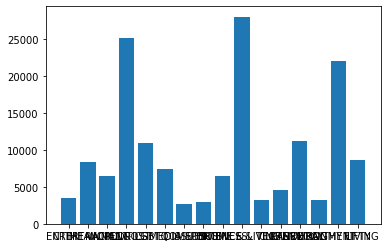

In [ ]:
from collections import Counter
from matplotlib import pyplot

counter = Counter(training['category'])
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

only SVM

In [ ]:
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE
oversample = SMOTE()

X, y = oversample.fit_sample(train_SVD, train_y)

counter = Counter(y)
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

SVM_model_linear = LinearSVC(C=1.0)
SVM_model_linear.fit(X, y)

##SVD + SVM Linear

In [ ]:
import os
import numpy as np
import csv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC




In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

le.fit(training['category'])
y_train = le.transform(training['category'])
print(y_train)

[ 2  4  4 ... 14 14 14]


In [ ]:
y_train = training['category']
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)

(155291, 12795)
(139480, 12795)
(155291,)


In [ ]:
from sklearn.model_selection import train_test_split
train_x, valid_x, train_y, valid_y = train_test_split(TF_train_x, y_train, test_size=0.1, random_state=42)
print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)

(139761, 12795)
(139761,)
(15530, 12795)
(15530,)


In [ ]:
#SVM_model_linear = LinearSVC(C=1.0)
#SVM_model_linear.fit(train_x, train_y)

#### SVD fit

In [ ]:
from sklearn.decomposition import TruncatedSVD
svd_model = TruncatedSVD(n_components = 30)
train_SVD = svd_model.fit_transform(train_x)
valid_SVD = svd_model.transform(valid_x)

In [ ]:
print(train_SVD.shape)
print(valid_SVD.shape)

(139761, 30)
(15530, 30)


每個類別選出10個最有影響力單字

In [ ]:
def print_topics(model, vectorizer, n_top_words):
  words = stemmed_vocab
  for topic_index, topic in enumerate(model.components_):
    print("\nTopic #%d:" % topic_index)
    print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    #print(topic.argsort()[:-n_top_words - 1:-1])

In [ ]:
print_topics(svd_model, TF_vectorizer, 10)


Topic #0:
paycheck academ involv eliot webster bridezilla malawi tequila meant jew

Topic #1:
bridezilla measur spaghetti precari aisl mango pelosi do tile raci

Topic #2:
paycheck academ chill paus scarc rollback reddit allegi tempt ty

Topic #3:
academ paus involv infus vibrat leia ahh rapper bridezilla awesom

Topic #4:
eliot jew academ rollback bridezilla mcilroy prize scapegoat ounc paus

Topic #5:
eliot paycheck involv menswear chill knive nomad newsbrief boe bridezilla

Topic #6:
involv jew bridezilla rollback popcorn rut sunni unkind measur prize

Topic #7:
webster bridezilla expans academ snitch measur infus jew mcilroy paycheck

Topic #8:
malawi scapegoat meant conjur oblig paycheck bridezilla academ measur wake

Topic #9:
tequila malawi webster scapegoat jew involv edinburgh woodi eliot motor


### f1 score - SVD

use subtrain and valid to calculate f1 score

SVD+SMV f1 score

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

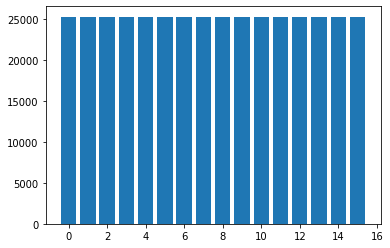

In [ ]:
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE
oversample = SMOTE()

X, y = oversample.fit_sample(train_SVD, train_y)

counter = Counter(y)
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

SVM_model_linear = LinearSVC(C=1.0)
SVM_model_linear.fit(X, y)

In [ ]:
from sklearn.metrics import classification_report

valid_pred = SVM_model_linear.predict(valid_SVD)

print(classification_report(valid_y, valid_pred))

              precision    recall  f1-score   support

           0       0.22      0.03      0.06       660
           1       0.15      0.04      0.06       293
           2       0.11      0.31      0.16       336
           3       0.10      0.01      0.01       435
           4       0.17      0.00      0.00       872
           5       0.11      0.15      0.13       353
           6       0.48      0.60      0.54       850
           7       0.52      0.63      0.57      2218
           8       0.61      0.69      0.65      2787
           9       0.18      0.14      0.16       687
          10       0.45      0.66      0.54      1134
          11       0.71      0.60      0.65      2571
          12       0.12      0.01      0.01      1082
          13       0.09      0.11      0.10       313
          14       0.07      0.12      0.09       301
          15       0.16      0.43      0.24       638

    accuracy                           0.44     15530
   macro avg       0.27   

## LDA

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [ ]:
from sklearn.model_selection import train_test_split
train_x, valid_x, train_y, valid_y = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
print(x_train.shape)
print(y_train.shape)
print(valid_x.shape)
print(valid_y.shape)

(155291, 12795)
(155291,)
(15530, 12795)
(15530,)


In [ ]:
lda_model = LDA(n_components = 10)
train_LDA = lda_model.fit_transform(train_x)
valid_LDA = lda_model.transform(valid_x)

In [ ]:
def print_topics(model, vectorizer, n_top_words):
  words = stemmed_vocab
  for topic_index, topic in enumerate(model.components_):
    print("\nTopic #%d:" % topic_index)
    print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    #print(topic.argsort()[:-n_top_words - 1:-1])

print_topics(lda_model, TF_vectorizer, 10)


Topic #0:
kill polic attack war year shoot peopl refuge say state

Topic #1:
trump donald presid clinton republican democrat say elect gop hillari

Topic #2:
food eat make travel recip photo day best way summer

Topic #3:
life parent time thing make love way kid peopl feel

Topic #4:
new award year appl film oscar puerto ebay week colleg

Topic #5:
new citi christma year day photo holiday san world music

Topic #6:
photo wed style check fashion dress look twitter facebook week

Topic #7:
year new video gay star game man black say film

Topic #8:
news huffpost rise trump hill jenner morn bush newsbrief welcom

Topic #9:
health studi new state peopl american care research tax risk


## Predict category

###inbalance category

resample data

imbalanced category:


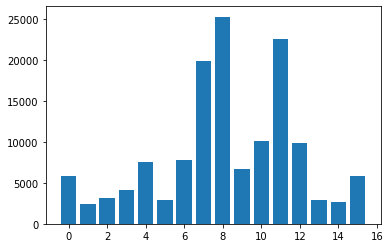

In [ ]:
from collections import Counter
from matplotlib import pyplot

print("imbalanced category:")
counter = Counter(train_y)

# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [ ]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X, y = oversample.fit_sample(train_LDA, train_y)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

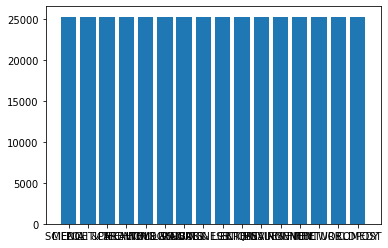

(404816, 10)
(404816,)


In [ ]:
counter = Counter(y)
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()
print(X.shape)
print(y.shape)

### LDA + SVC fit

In [ ]:
from sklearn.svm import LinearSVC
SVM_model_linear = LinearSVC(C=1.0)
SVM_model_linear.fit(X, y)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
from sklearn.metrics import classification_report

valid_pred = SVM_model_linear.predict(valid_LDA)

print(classification_report(valid_y, valid_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

             BUSINESS       0.14      0.42      0.21       660
               COMEDY       0.00      0.00      0.00       293
                CRIME       0.00      0.00      0.00       336
              CULTURE       0.06      0.00      0.00       435
        ENTERTAINMENT       0.18      0.04      0.06       872
          ENVIRONMENT       0.00      0.00      0.00       353
                FIFTY       0.21      0.30      0.24       850
       HEALTHY LIVING       0.37      0.04      0.06      2218
        HOME & LIVING       0.57      0.53      0.55      2787
                MEDIA       0.00      0.00      0.00       687
            PARENTING       0.22      0.60      0.32      1134
             POLITICS       0.64      0.65      0.64      2571
RACIAL & LGBTQ ISSUES       0.00      0.00      0.00      1082
 SCIENCE & TECHNOLOGY       0.10      0.10      0.10       313
               SPORTS       0.09      0.57      0.16  

### KNN classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

KNN_model = KNeighborsClassifier(n_neighbors=10, weights='distance')

In [ ]:
KNN_model.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [ ]:
valid_pred = KNN_model.predict(valid_LDA)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(valid_y, valid_pred))

                       precision    recall  f1-score   support

             BUSINESS       0.12      0.21      0.15       660
               COMEDY       0.04      0.13      0.06       293
                CRIME       0.06      0.15      0.08       336
              CULTURE       0.04      0.08      0.05       435
        ENTERTAINMENT       0.17      0.18      0.17       872
          ENVIRONMENT       0.05      0.13      0.07       353
                FIFTY       0.14      0.21      0.17       850
       HEALTHY LIVING       0.36      0.20      0.26      2218
        HOME & LIVING       0.64      0.37      0.47      2787
                MEDIA       0.06      0.07      0.06       687
            PARENTING       0.19      0.17      0.18      1134
             POLITICS       0.68      0.37      0.48      2571
RACIAL & LGBTQ ISSUES       0.13      0.07      0.09      1082
 SCIENCE & TECHNOLOGY       0.06      0.11      0.07       313
               SPORTS       0.06      0.13      0.08  

### KNN pred testing



In [ ]:
all_news_n3 = testing.copy()
all_news_n3['category'] = y_pred

In [ ]:
train_c = pd.DataFrame({'train':Counter(training.category)})
test_c = pd.DataFrame({'test':Counter(all_news_n3.category)})
categories = train_c.merge(test_c, left_index=True, right_index=True)

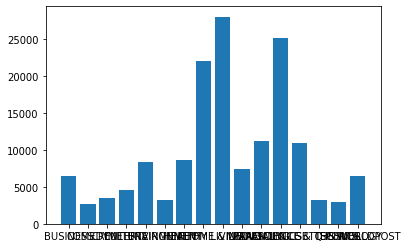

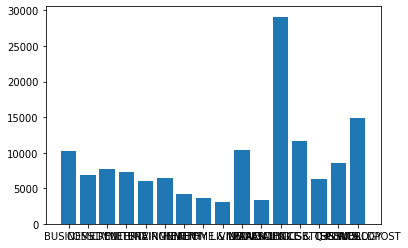

In [ ]:
# plot train category
pyplot.bar(categories.index, categories['train'])
pyplot.show()

# plot test category
pyplot.bar(categories.index, categories['test'])
pyplot.show()

In [ ]:
# plot train category
pyplot.bar(train_c.keys(), train_c.values())
pyplot.show()

# plot test category
pyplot.bar(test_c.keys(), test_c.values())
pyplot.show()

TypeError: ignored

In [ ]:
all_news_kn3 = df_test.copy()
all_news_kn3['category'] = y_pred
print("title:\n", all_news_kn3.title[10000])
print("content:\n", all_news_kn3.content[10000])
print("predict:\n",all_news_kn3.category[10000])

title:
 Watch: Spicer Asked How It Feels ’To Work for a Fascist?’ In Apple Store - Breitbart
content:
 Asking @PressSec questions in Apple Store since he doesn’t like the press.  https:  .  While shopping at an Apple Store, White House Press Secretary Sean Spicer was asked whether he had committed treason and how he felt about working for a fascist.  In the video, which was posted on Saturday by Twitter account @shreec, Spicer is asked how it feels “to work for a fascist?” He is further asked, “Have you helped with the Russia stuff? Are you a criminal as well? Have you committed treason too, just like the president?   …     What can you tell me about Russia?” Spicer responded by saying “Thank you” and “such a great country that allows you to be here. ” Spicer then goes about his business in the store, ignoring questions about how he feels about working for a fascist, destroying the country, and lying to the public. (  The Hill) Follow Ian Hanchett on Twitter @IanHanchett
predict:
 ENTE

In [ ]:
print("title:\n", all_news_kn3.title[0])
print("content:\n", all_news_kn3.content[0])
print("predict:\n",all_news_kn3.category[0])

title:
 House Republicans Fret About Winning Their Health Care Suit - The New York Times
content:
 WASHINGTON  —   Congressional Republicans have a new fear when it comes to their    health care lawsuit against the Obama administration: They might win. The incoming Trump administration could choose to no longer defend the executive branch against the suit, which challenges the administration’s authority to spend billions of dollars on health insurance subsidies for   and   Americans, handing House Republicans a big victory on    issues. But a sudden loss of the disputed subsidies could conceivably cause the health care program to implode, leaving millions of people without access to health insurance before Republicans have prepared a replacement. That could lead to chaos in the insurance market and spur a political backlash just as Republicans gain full control of the government. To stave off that outcome, Republicans could find themselves in the awkward position of appropriating huge 

### SVM

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.svm import SVC

In [ ]:
print(train_x.shape)
print(train_y.shape)

(155291, 12795)
(155291,)


In [ ]:
SVM_model_linear = SVC()
SVM_model_linear.fit(train_x,train_y)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
test_pred = SVM_model_linear.predict(valid_SVD)

ValueError: ignored

In [ ]:
counter = Counter(test_pred)

# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()